# STA 561 HW 5 {-}

Authors  
 -  Alonso Guerrero Castaneda (UID: 1194613)  
 -  Eli Gnesin (UID: 1172961)  
 -  Tommy Misikoff (UID: 1166813)  
 -  Sanskriti Purohit (UID: 1179957)  
 -  Will Tirone (UID: 1130904)  

TA: Rick Presman 

In [5]:
# Import Libraries
import numpy as np
import pandas as pd
import random
import numpy.random as nr
from sklearn import datasets
import matplotlib.pyplot as plt

### Question 3 {-}

For our implementation of this function, we consider $P$ to be a uniform distribution across the integers $\{k_{min}, k_{min}+1, ..., k_{max}\}$ by default, but allow the user to pass in some other callable sampling function that will sample over the same range. Likewise, $Q$ defaults to a $N(0,1)$ distribution, but Q can be any callable function that takes in two arguments $(k^{(b)}, p)$ and gives a $k^{(b)} \times p$ matrix of randomly sampled values. For this implementation, this is most easily done with a `lambda` function on a NumPy function for a sampling distribution with the correct parameters (mean of 0, variance of 1), with the `lambda` function arguments for the size.

In [6]:
def Randy(X, y, B = 1000, Q = lambda x,y: np.random.default_rng(seed = 19).normal(0, 1, (x,y)), k_min = 1, k_max = 100, P = None):
    
    n = len(y)
    p = X.shape[1]
    
    Sigma = np.zeros(shape = (p, p))
    Gamma = np.zeros(shape = (p, 1))
    Beta = np.zeros(shape = (p, 1))

    #First, we need to calculate Sigma and Gamma
    for i in range(0, n):
        data_temp = np.asarray(X.iloc[i,]).reshape(-1,1)
        targ_temp = y[i]
        Sigma_temp = data_temp @ data_temp.T
        Gamma_temp = data_temp * targ_temp
        
        Sigma = Sigma + Sigma_temp
        Gamma = Gamma + Gamma_temp
    
    Sigma = (1/n) * Sigma
    Gamma = (1/n) * Gamma
    
    #Now we need to calculate our B estimates for Beta
    for i in range(0, B):
    
        #Sample k_b from P(k)
        if P is not None:
            k_b = P(k_min, k_max)
        else:
            k_b = random.randint(k_min, k_max)
            
        Omega = Q(k_b, p)
        Inter = Omega @ Sigma @ Omega.T
        proj_beta = Omega.T @ np.linalg.inv(Inter) @ Omega @ Gamma
        
        Beta = Beta + proj_beta
        
    Beta_ave = (1/B) * Beta
    
    return Beta_ave

In [7]:
nr.seed(1)
X, y, t_coef = datasets.make_regression(n_samples=10000,n_features=100,n_informative=100,coef=True)
X = pd.DataFrame(X)
Beta_ave = Randy(X,y,k_min=10,k_max=20)

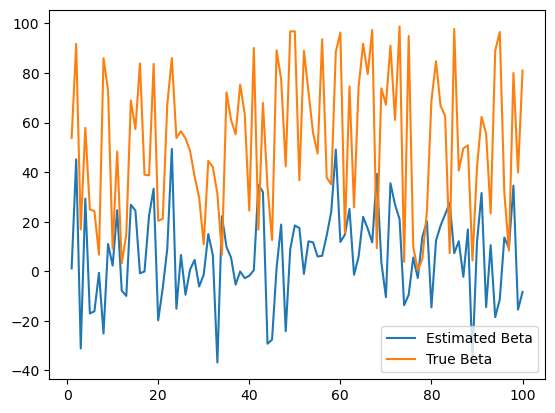

In [8]:
plt.plot(range(1,X.shape[1]+1),Beta_ave, label = "Estimated Beta")
plt.plot(range(1,X.shape[1]+1), t_coef, label = "True Beta")
plt.legend()
plt.show()

### Question 4 {-}

This problem is basically a projection error minimization problem. While this could be solved numerically, we can obtain a closed form solution for the optimal $\Omega$ by realizing this is just an alternative formulation of PCA. 

See lectures notes from Radu Horaud (http://perception.inrialpes.fr/~Horaud/Courses/pdf/Horaud-DAML5.pdf) or alternatively the original chapter 12 of Bishop (2006) (http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) for the complete derivation. Bishop (2006) showed that the solution to this minimization problem is choosing the K largest eigenvectors of the covariance X. 

So our function defines function `fn` that computes the objective function, `k_dim_embedding`, which computes the eigenvectors, and then runs the simulations based on synthetic data. This true synthetic data is generated using a linear model with Guassian noise. Then we plot a comparison between the values obtained in the objective function fn from both methods and then we do the same for the out-of-sample MSE. 

As we can see in the first plot, by construction, the objective function takes values very close to zero for the optimal solution, while is fairly random given a random projection. Now, the interesting part is that the second plot reveal very similar out-of-sample MSEs. That is, it doesn't appear to make much of a difference using a random projection compared to the "optimal" one. 

In [9]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd

# Objective function fn
def fn(Omega, X):
    n, p = X.shape
    X_Omega = X @ Omega.T
    inner_products = X @ X.T
    Omega_inner_products = X_Omega @ X_Omega.T
    return np.sum((inner_products - Omega_inner_products)**2)

# K-dim embedding function
def k_dim_embedding(X, k):
    n, p = X.shape
    # Covariance matrix
    cov_X = np.cov(X.T)
    # Top k eigenvectors of covariance
    eigenvalues, eigenvectors = np.linalg.eigh(cov_X)
    # Take k eigenvectors corresponding to the k largest eigenvalues
    Omega_kdim = eigenvectors[:, -k:]
    # Return Omega as a (k, p) matrix
    return Omega_kdim.T

# Parameters
n = 1000 # sample size
p = 50 # number of dimensions/regressors
k = 10 # number of reduced dimensions
n_simulations = 100  # number of simulations
beta_true = np.random.normal(size=p) # true beta coefficients

# Results dataframe
results_df = pd.DataFrame(columns=['Simulation', 'Method', 'fn', 'MSE'])

for i in range(n_simulations):
    # Generate  data
    X = np.random.normal(size=(n, p))
    e = np.random.normal(size=n)
    y = X @ beta_true + e
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Calculate fn and MSE for random projection method
    # We choose random normal 
    Omega_random = np.random.normal(size=(k, p))
    fn_random = fn(Omega_random, X_train)
    model_random = LinearRegression()
    X_train_random = X_train @ Omega_random.T
    model_random.fit(X_train_random, y_train)
    y_pred_random = model_random.predict(X_test @ Omega_random.T)
    mse_random = np.mean((y_test - y_pred_random)**2)
    results_df = pd.concat([results_df, pd.DataFrame({'Simulation': [i+1], 'Method': ['Random Projection'], 'fn': [fn_random], 'MSE': [mse_random]})])
    
    # Calculate fn and MSE for k-dim embedding method
    Omega_kdim = k_dim_embedding(X_train, k)
    fn_kdim = fn(Omega_kdim, X_train)
    model_kdim = LinearRegression()
    X_train_kdim = X_train @ Omega_kdim.T
    model_kdim.fit(X_train_kdim, y_train)
    y_pred_kdim = model_kdim.predict(X_test @ Omega_kdim.T)
    mse_kdim = np.mean((y_test - y_pred_kdim)**2)
    results_df = pd.concat([results_df, pd.DataFrame({'Simulation': [i+1], 'Method': ['K-dim Embedding'], 'fn': [fn_kdim], 'MSE': [mse_kdim]})])
    
results_df.reset_index(drop=True, inplace=True)
print(results_df)


    Simulation             Method            fn        MSE
0            1  Random Projection  1.498687e+10  34.408344
1            1    K-dim Embedding  2.126382e+07  34.380947
2            2  Random Projection  2.305442e+10  30.869338
3            2    K-dim Embedding  2.179266e+07  37.408577
4            3  Random Projection  1.639729e+10  30.611716
..         ...                ...           ...        ...
195         98    K-dim Embedding  2.221292e+07  23.618199
196         99  Random Projection  2.038505e+10  34.981071
197         99    K-dim Embedding  2.194623e+07  34.481668
198        100  Random Projection  2.135284e+10  38.911853
199        100    K-dim Embedding  2.183232e+07  39.331379

[200 rows x 4 columns]


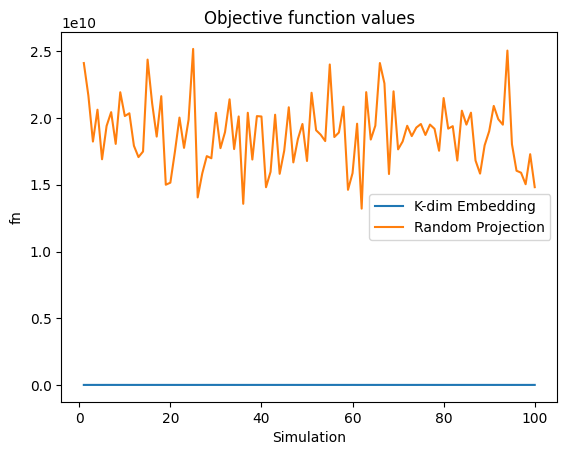

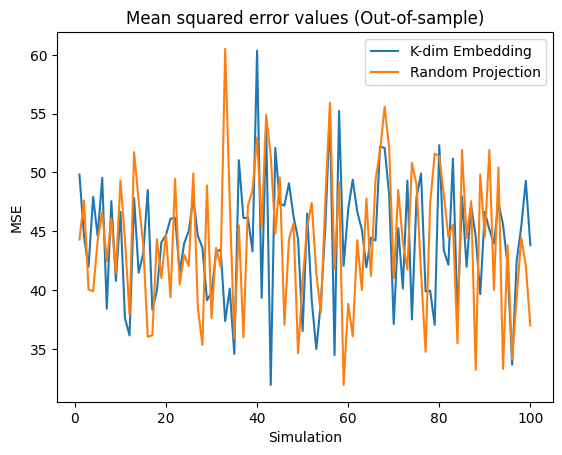

In [64]:
import matplotlib.pyplot as plt

# Plot 1: fn values for each simulation
fig, ax = plt.subplots()
for key, grp in results_df.groupby('Method'):
    ax = grp.plot(ax=ax, kind='line', x='Simulation', y='fn', label=key)
ax.set_xlabel('Simulation')
ax.set_ylabel('fn')
ax.set_title('Objective function values')
plt.show()

# Plot 2: MSE values for each simulation
fig, ax = plt.subplots()
for key, grp in results_df.groupby('Method'):
    ax = grp.plot(ax=ax, kind='line', x='Simulation', y='MSE', label=key)
ax.set_xlabel('Simulation')
ax.set_ylabel('MSE')
ax.set_title('Mean squared error values (Out-of-sample)')
plt.show()
